# 4.1 Analytical model for MLTSA

## Imports

In [1]:
import sys
sys.path.append('src/') # We add the src folder to the path python will search for modules
import OneD_pot_data as oned
import matplotlib.pyplot as plt
import numpy as np

### Aims of this Notebook

This is an example notebook on how to generate data with the 1D analytical model to analyze relevant features at the transition state from mixed data.

You will learn: 
1. Generate 1D complex data for analyzing and evaluating different ML models. 
2. Setup a ML model with Scikit-Learn (MLP and GBDT)
3. Pipeline the MLTSA to obtain the relevant features correlated with the outcome.

## Introduction

The Machine Learning Transition State Analysis (MLTSA) is a method that allows us to analyze relevant features for the transition state (TS) of a physical system from downhill simulations that could end up in diferent states. This is specially useful for example, when simulating ligand binding/unbinding events where from starting simulations at the approximated TS, and sampling the ligand binding (IN) and unbinding (OUT) we can generate data to teach a ML model to predict the outcome from early on data (near-TS). To get in touch with the method we will use an analytical model as an example, where we have two types of potentials we will generate data on:

<center>
<img src="images/SWvsDW.png" alt="SWvsDW" width="800"/>
</center>

Let's suppose we have a system with multiple states described by both _(a)_ Single Well (SW) and _(b)_ Double Well (DW) potentials. To simulate a real life scenario in our analytical model, like we do with distances on other systems, we can draw as many SW and DW potentials from the system as we want (or have), but the reaction we are looking at may be governed by only **one** of the multiple DW potentials we can draw, while the rest (including SWs) are just **noise** and are unrelated to the reaction. Analogous to when working with real life problems, we will generate data on this potentials at the same time, and try to search for this relevant potential among the noise. 


The simulations we will run on each of the potentials are using the Brownian Overdamped Langevin Dynamics equation: 

<center>
<img src="images/langevin.png" alt="SWvsDW" width="300"/>
</center>

Where 𝛾 = 0.01 is constant along x and 𝜂(𝑡) is a number randomly sampled from a normal
(Gaussian) distribution centred at 0 and the spread is 1.0.

As one may already think, just using the coordinates straight from the data would inmidiately give away the relevant DW out of all the SWs/DWs available, their value would correlate with the state they would fall on by the end (left/right minima), which we will call IN/OUT. 


In order to make it harder for the ML model to learn the answer, we will linearly mix the coordinates generated from the different potentials, to generate new features in this way:


<center>
<img src="images/analytical_model.png" alt="SWvsDW" width="800"/>
</center>


This way we can generate as much features (y<sub>feature</sub>) as we want and all potentials (y<sub>sw</sub> , y<sub>dw</sub>) will be differently **mixed** (different $\alpha$). If you generate 180 potentials, two randomly chosen potentials would be mixed with different coefficients ($\alpha$)each time. Among these, some of them will be mixed with the **relevant DW** (y*<sub>dw</sub>), which would made them **correlated to the trajectory outcome** (IN/OUT). The bigger the $\alpha$ the more correlated to the answer a given y<sub>feature</sub> will be. These potentials are the ones we want to be able to pinpoint using the ML. On the left you have a representation of the trajectory coordinates on the original relevant DW (y*<sub>dw</sub>), how the data would look like when mixing it with a SW (y*<sub>dw</sub> and y<sub>sw</sub>) and how it would look like when mixed with other non relevant DW (y*<sub>dw</sub> and y<sub>dw</sub>).

Additionally, to make it even harder, we will also **only use data closer to the beggining of the trajectories** (Shaded in blue), where both outcomes are mixed the most, so it would be very hard to guess which feature is giving the answer away by simply looking at them.

------

## Hands-on code

### Generating the trajectories

We will start by defining the number of SW and DW potentials we want to have on our model. In order to do that we can call the `potentials` class which will need the total number of potentials we want to generate, the number of DW potentials to have in it, and the potential we want to be relevant. 

In [2]:
#This sets the potentials, don't re-run
total_n_pots = 25
n_DW = 2
relevant_DW_n = 1
#After defining the desired parameters we define the potentials accordingly
pots = oned.potentials(total_n_pots, n_DW, relevant_DW_n, plot=False)

Defining Potentials: 100%|###########################################################| 25/25 [00:00<00:00, 1085.97it/s]


We can check the different shapes of the potentials we generated using the .shape atribute, we will get the X and Y values for the defined potentials which we can use to plot and verify their shape:

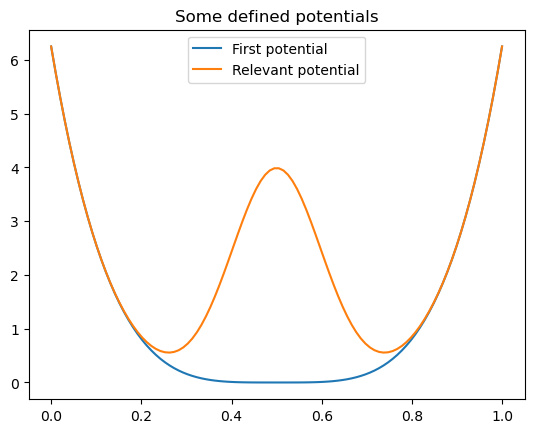

In [3]:
pots_shapes = pots.shape #Checking the shapes
plt.title("Some defined potentials")
plt.plot(pots_shapes[0][0], pots_shapes[0][1], label="First potential"); #Each entry has the X and Y values of the potential
plt.plot(pots_shapes[pots.relevant_id][0], pots_shapes[pots.relevant_id][1], label="Relevant potential");
plt.legend()

As you can see, our relevant potential is indeed a DW, now that we defined them we have to generate trajectories on them starting from the "TS" (at 0).

In [4]:
n_sims = 10 #Number of desired trajectories
n_steps = 500 #Number of steps to run the trajectories for

#This will create our original unmixed data
#it also gives you the outcomes for the ran trajectories depending on your relevant DW
simple_data, answers = pots.generate_data(n_sims, n_steps) #This generates simple data
print("Data has the shape of", simple_data.shape, "as in (n_sims, n_pot, n_steps)")

Generating dataset


Running Simulations: 100%|#############################################################| 10/10 [00:02<00:00,  4.64it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|#########################################################| 10/10 [00:00<?, ?it/s]

Data has the shape of (10, 25, 500) as in (n_sims, n_pot, n_steps)


Now that we generated the data we can plot it to see how it looks like:

(0.0, 1.0)

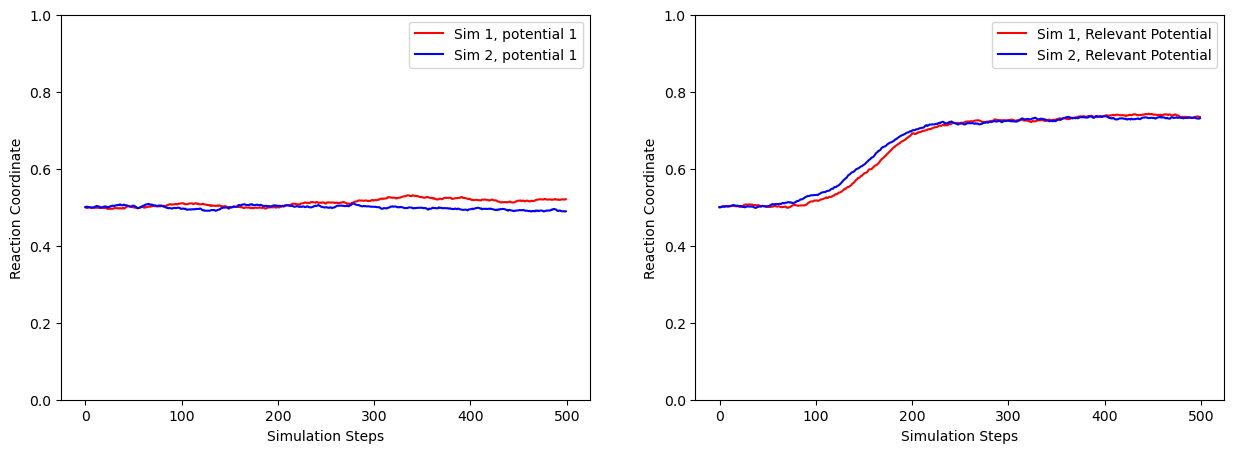

In [5]:

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(simple_data[0,0,:], color="r", label="Sim 1, potential 1")
axs[1].plot(simple_data[0,pots.relevant_id,:], color="r", label="Sim 1, Relevant Potential")
axs[0].plot(simple_data[-1,0,:], color="b", label="Sim 2, potential 1")
axs[1].plot(simple_data[-1,pots.relevant_id,:], color="b", label="Sim 2, Relevant Potential")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Simulation Steps")
axs[1].set_ylabel("Reaction Coordinate")
axs[0].set_xlabel("Simulation Steps")
axs[0].set_ylabel("Reaction Coordinate")
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)

As you can see, the generated data looks good, and indeed just looking at the relevant potential coordinates, we can easily find the relevant value that separates both classes (IN/OUT), whereas the first potential is noisy. 

### Let's make it hard to predict

We will now create the linear combination data from the given trajectories. For this we will use the `dataset` class, which needs the previously defined potentials, desired number of features and the degree of mixing (how many to combine per feature)

In [6]:
# This creates the first set of data.
# It creates the mixing coefficients don't re-run or they override
n_features = 100 #Number of features to create
degree_of_mixing = 2 # Degree of mixing coordinates

#We specified the number of features wanted and how much they will mix
oneD_dataset = oned.dataset(pots, n_features, degree_of_mixing)

Now that they are defined, we can also directly generate as many new trajectories as we want by simply calling `.generate_linear()` on the new `oneD_dataset` object with the number of steps to run for and the number of simulations to generate. It also gives you the outcomes as well so it is conviniently doing everything for you so you can put it in your testing pipeline or generate new data as you iterate. 

In [7]:
n_simulations = 50
n_steps = 500
data, ans = oneD_dataset.generate_linear(n_simulations, n_steps)
print("The data shape is ", data.shape, "as in (n_sims, n_features, n_steps)")

Generating dataset


Running Simulations: 100%|###########################################################| 100/100 [00:21<00:00,  4.64it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|#######################################################| 100/100 [00:00<?, ?it/s]

The data shape is  (100, 100, 500) as in (n_sims, n_features, n_steps)


(0.0, 1.0)

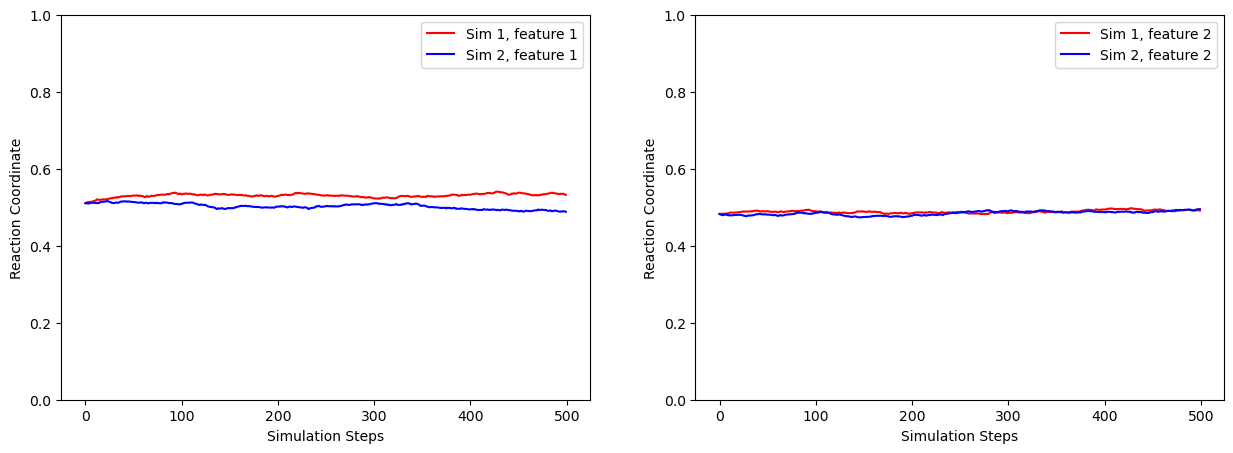

In [8]:
#We proceed to plot the values
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(data[0,0,:], color="r", label="Sim 1, feature 1")
axs[1].plot(data[0,-1,:], color="r", label="Sim 1, feature 2")
axs[0].plot(data[1,0,:], color="b", label="Sim 2, feature 1")
axs[1].plot(data[1,-1,:], color="b", label="Sim 2, feature 2")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Simulation Steps")
axs[1].set_ylabel("Reaction Coordinate")
axs[0].set_xlabel("Simulation Steps")
axs[0].set_ylabel("Reaction Coordinate")
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)

Now it is way harder to find which one is relevant. Let's get to train the ML models to predict the future!

### Forecasting the outcome of the trajectories

Our first step is defining the models to train. For this we will use Scikit-learn and their awesome library which allows for easy training of ML models. We will use 2 popular models MLP, a Multi-Layer Perceptron which is basically a Neural Network with 3 layers (input, hidden, output), and Gradient Boosting Decision Tree (GBDT) which is a decision tree model which passes by the data sequentially to find the best splits to predict the outcome. 

In [9]:
from sklearn.neural_network import MLPClassifier #Multi-Layer Perceptron model
from sklearn.ensemble import GradientBoostingClassifier #Decision Tree model
from sklearn.model_selection import train_test_split #This will split our data randomly for training/validation

In [10]:
MLP = MLPClassifier(verbose=False, max_iter=500) #You can modify Hyperparameters here
GBDT = GradientBoostingClassifier(verbose=False, n_estimators=50) #You can modify Hyperparameters here

Now that our models are defined with the desired parameters, we have to prepare the data for training. As we said, we will be training at early times to evaluate how good the models are at predicting while checking if they can detect the correlated features at all. These models take only 2 dimensions, therefore we cannot predict per trajectory but rather try to predict based on single frames, so the data will have to be concatenated. `n_frames = n_steps*n_sims`. Remember X is our input data (features) and Y is our target. In this case Y will be if the single farmes belong to an "IN" or "OUT" class. You can try to print them if it's easier to understand. 

In [11]:
time_frame = [20, 50] #From when to when to train on
X, Y = oneD_dataset.PrepareData(data, ans, time_frame, mode="Normal")
print("The input data is in the shape of X:", X.shape,"Y:", Y.shape)
print("It needs the shape of (n_frames, n_features) and (n_frames)" )

The input data is in the shape of X: (3000, 100) Y: (3000,)
It needs the shape of (n_frames, n_features) and (n_frames)


To train the models we simply have to call `.fit()` so Scikit-learn will take care of the training for us. But before we will split on training data and test data. 

In [12]:
#Splitting the data randomly for train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) 
#########################################################
#Training MLP
print("Training MLP")
MLP.fit(X_train, Y_train)
print("Training ended")
Y_pred = MLP.predict(X_test)
MLP_accuracy = np.mean(Y_pred == Y_test)
print("MLP did:", MLP_accuracy*100, "% accuracy on test")
##########################################################
#Training GBDT
print("Training GBDT")
GBDT.fit(X_train, Y_train)
print("Training ended")
Y_pred = GBDT.predict(X_test)
GBDT_accuracy = np.mean(Y_pred == Y_test)
print("GBDT did:", GBDT_accuracy*100, "% accuracy on test")
############################################################

Training MLP
Training ended
MLP did: 91.2 % accuracy on test
Training GBDT
Training ended
GBDT did: 98.13333333333333 % accuracy on test


They both do a good job at predicting this early, keep in mind that MLP takes less time to train than GBDT. Let's do the feature analysis now and try to see if they can detect the features correlated to the relevant DW

### Finding relevant features

Thanks to the training of the GBDT we can simply plot the Gini Feature Importance and take a look at what's important

In [13]:
from MLTSA import ADROP
from MLTSA import MLTSA_ADROP_Plot
from MLTSA import MLTSA_FeatImp_Plot

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
src\MLTSA.py:194: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dat, "-o", color="black", marker="s")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


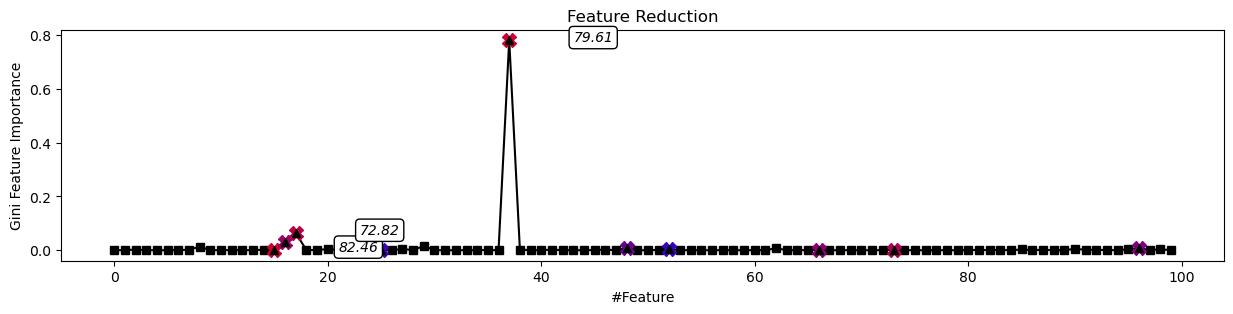

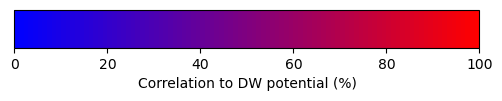

In [14]:
correlation_threshold = 70 #Percentage threshold to show textbox with correlation value
MLTSA_FeatImp_Plot([GBDT.feature_importances_], oneD_dataset, pots, correlation_threshold)

If everything went correctly, you should be able to see that the GBDT has been able to detect at least the most important feature, which has the highest correlation to the relevant DW potential value. 

When trying to look at the relevant features for our MLP, we can't do it like GBDT, we instead rely on the accuracy drop (ADROP) also known as feature permutation/feature substitution. In this case what we do is we change one feature at a time so the feature stays with the global mean value across trajectories for all samples through time. This way we cancel the variance and the information from the feature is cancelled. Thus, if we re-predict the original training data with this modification one at a time, we can get a drop in accuracy, correlated with the importance the feature had for the model to predict. 

In [15]:
from tqdm import tqdm

def ADROP(data, ans, model):
    # Calculating the global means from training data
    means_per_sim = np.mean(data.T, axis=0)
    gmeans = np.mean(means_per_sim, axis=1)
    temp_sim_data = np.copy(data)
    
    #Repredicting with the modified data
    adrop = []
    for y, d in tqdm(enumerate(temp_sim_data), desc="Recalculating accuracy"):
        mean_sim = []
        for n, mean in enumerate(gmeans):
            tmp_dat = np.copy(d)
            tmp_dat[n, :] = mean
            yy = np.zeros(len(tmp_dat.T)).astype(str)
            yy[:] = ans[y]
            res = model.score(tmp_dat.T, yy)
            mean_sim.append(res)
        adrop.append(mean_sim)
        
    return adrop
    

In [16]:
accuracy_drop = ADROP(data[:,:, time_frame[0]:time_frame[1]], ans, MLP) #Remember to use the data in the range we used for training. 
adrop = np.mean(accuracy_drop, axis=0) #Mean across trajectories
adrop = adrop/np.max(adrop) #Calculating relative drop

Recalculating accuracy: 100it [00:03, 31.78it/s]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
src\MLTSA.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dat, "-o", color="black", marker="s")


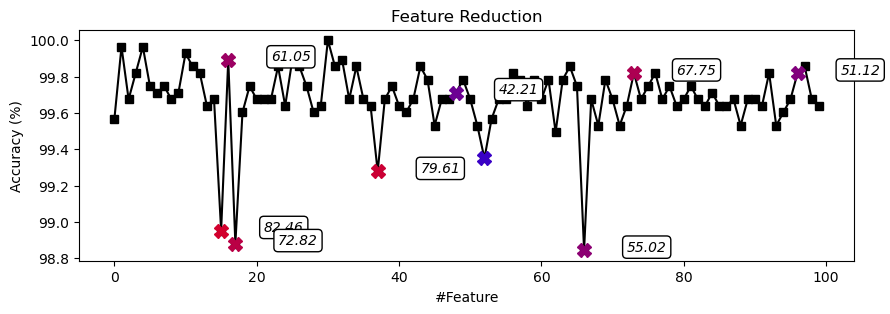

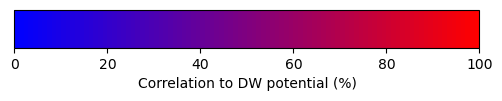

In [17]:
correlation_threshold = 80 #Percentage threshold to show textbox with correlation value
MLTSA_ADROP_Plot([adrop], oneD_dataset, pots, correlation_threshold)

Comparing the two previous graphs, you can see that the GBDT is more sensible to really important features, whereas MLP with ADROP can pinpoint almost all relevant correlated features. 

## Optional tasks


We recommend if time allows, or at home, to try the following:
- Try changing the data generation parameters such as number of DW to higher numbers or the degree of mixing to higher numbers. How do the ML models react to it? Are they still so accurate?
<!-- ***Answer:*** The accuracy drops as the complexity increases.-->
- Try also changing the time_frame at which we predict, what is the accuracy at later times? What about earlier? The whole trajectory?.
<!-- ***Answer:*** At later times it should be easier to predict whereas at earlier times it should be harder .-->
- While increasing complexity, compare the accuracy with n_sim=50 to n_sim=250.
<!-- ***Answer:*** Increasing the number of samples increases accuracy as well.-->